# Fraud Analytics

The purpose of this notebook will be to explore different traditional methods and propose novel ways to work with unbalanced datasets. A dataset is called as unbalanced when the response variable is unusually skewed towards one outcome. Common examples are datasets tracking fraud transactions and customer churn. One of the biggest challenge working with such datasets is that while building predictive models, the algorithm choose to just ignore the minority outcome. As such, analysis of unbalanced datasets requires special attention and approach. 

In this example, I am using an anonymized credit card transaction dataset from <a href="https://www.kaggle.com/dalpozz/creditcardfraud">Kaggle</a>.    

#### 1. Read in the data

In [1]:
ccdata <- read.csv('creditcard.csv')

##### Distribution of response variable

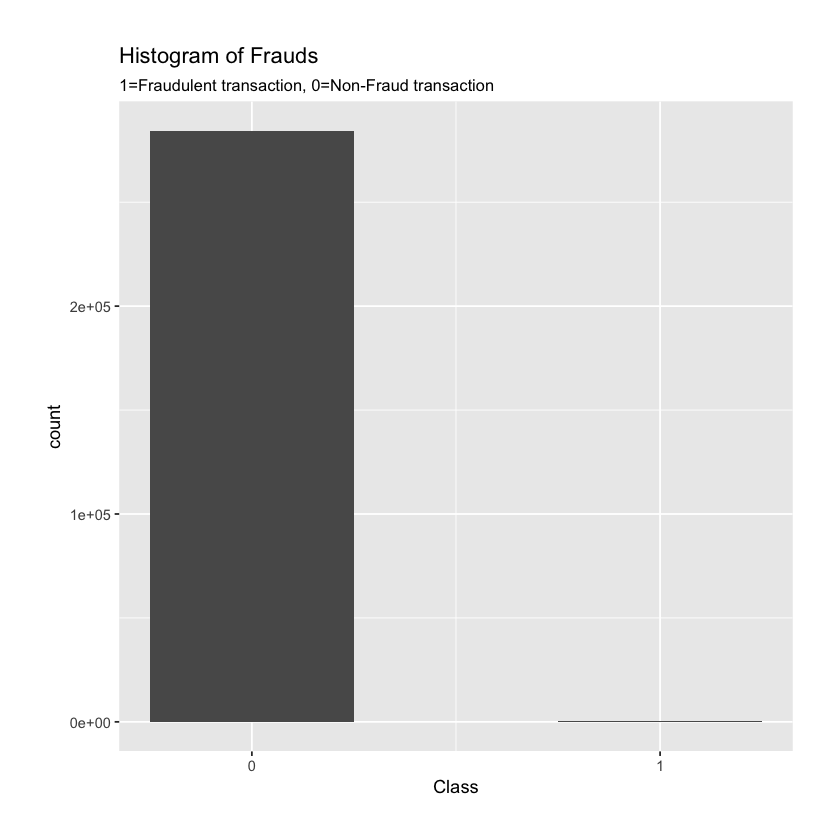

In [20]:
library(ggplot2)

ggplot(ccdata, aes(Class)) + geom_histogram(binwidth = 0.5)+
  scale_x_continuous("Class", breaks = seq(0,1,by = 1))+
  ggtitle("Histogram of Frauds", subtitle = "1=Fraudulent transaction, 0=Non-Fraud transaction") +
  theme(plot.margin = unit(c(1, 1, 1, 1), "cm"))

In [3]:
# In numbers and proportion
table(ccdata$Class)
prop.table(table(ccdata$Class))


     0      1 
284315    492 


          0           1 
0.998272514 0.001727486 

#### 2. Build an initial model

##### 2.1 Split the data into train and test sets

In [4]:
library(caret)
set.seed(1234)
splitIndex <- createDataPartition(ccdata$Class, p = .50,
                                  list = FALSE,
                                  times = 1)
trainSplit <- ccdata[ splitIndex,]
testSplit <- ccdata[-splitIndex,]

paste0("Table of proportions in the training and test splits:")
prop.table(table(trainSplit$Class))
prop.table(table(testSplit$Class))

Loading required package: lattice


[1] "Table of proportions in the training and test splits:"


          0           1 
0.998321676 0.001678324 


          0           1 
0.998223352 0.001776648 

##### 2.2 Model using treebag

In [5]:
ctrl <- trainControl(method = "cv", number = 2)
tbmodel <- caret::train(Class ~ ., data = trainSplit, method = "treebag",
                        trControl = ctrl)

predictors <- names(trainSplit)[names(trainSplit) != 'target']
pred <- predict(tbmodel$finalModel, testSplit[,predictors])

Loading required package: ipred
Loading required package: plyr
Loading required package: e1071
Warning message in train.default(x, y, weights = w, ...):
“You are trying to do regression and your outcome only has two possible values Are you trying to do classification? If so, use a 2 level factor as your outcome column.”

##### 2.3 Evaluate the model using AUC

Type 'citation("pROC")' for a citation.

Attaching package: ‘pROC’

The following objects are masked from ‘package:stats’:

    cov, smooth, var




Call:
roc.default(response = testSplit$Class, predictor = pred)

Data: pred in 142150 controls (testSplit$Class 0) < 253 cases (testSplit$Class 1).
Area under the curve: 0.9208


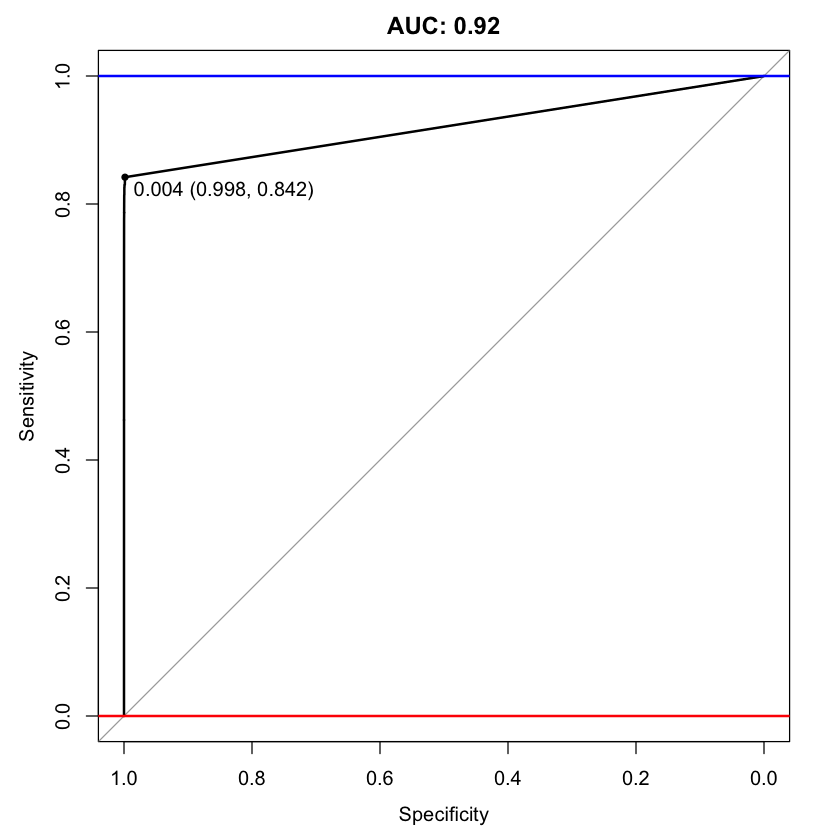

In [7]:
library(pROC)
auc <- roc(testSplit$Class, pred)
print(auc)
plot(auc, ylim=c(0,1), print.thres=TRUE, main=paste('AUC:',round(auc$auc[[1]],2)))
abline(h=1,col='blue',lwd=2)
abline(h=0,col='red',lwd=2)

#### 3. Use SMOTE 

Synthetic minority over-sampling (SMOTE) technique is used to synthetically increase the occurances of minority cases (Class = 1) in the dataset

In [9]:
library(DMwR)

trainSplit$Class <- as.factor(trainSplit$Class)
trainSplit <- SMOTE(Class ~ ., trainSplit, perc.over = 100, perc.under=200)
trainSplit$Class <- as.numeric(trainSplit$Class)

paste0("Table of proportions after SMOTE in the training set:")
prop.table(table(trainSplit$Class))

[1] "Table of proportions after SMOTE in the training set:"


  1   2 
0.5 0.5 

##### 3.1 Re-build the model

In [10]:
tbmodel <- caret::train(Class ~ ., data = trainSplit, method = "treebag",
                        trControl = ctrl)

predictors <- names(trainSplit)[names(trainSplit) != 'Class']
pred <- predict(tbmodel$finalModel, testSplit[,predictors])

Warning message in train.default(x, y, weights = w, ...):
“You are trying to do regression and your outcome only has two possible values Are you trying to do classification? If so, use a 2 level factor as your outcome column.”

##### 3.2 Evaluate the new model


Call:
roc.default(response = testSplit$Class, predictor = pred)

Data: pred in 142150 controls (testSplit$Class 0) < 253 cases (testSplit$Class 1).
Area under the curve: 0.9791


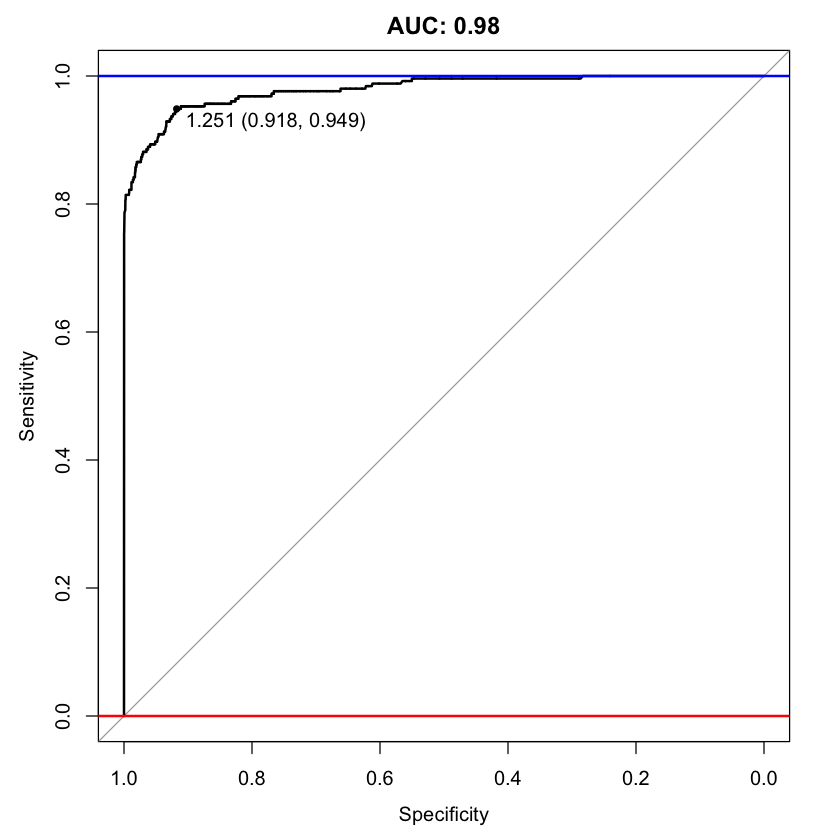

In [11]:
auc <- roc(testSplit$Class, pred)
print(auc)

plot(auc, ylim=c(0,1), print.thres=TRUE, main=paste('AUC:',round(auc$auc[[1]],2)))
abline(h=1,col='blue',lwd=2)
abline(h=0,col='red',lwd=2)